# Import Libraries

In [1]:
# Pandas
import pandas as pd

# Numpy 
import numpy as np
from numpy.random import seed
seed(1)

# Keras
from keras import backend
from keras.layers import Dense, Flatten, Dropout, LSTM, ConvLSTM2D, TimeDistributed
from keras.models import Sequential
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.losses import mean_squared_error
from tensorflow import set_random_seed
set_random_seed(2)

# Matplotlib and Seaborn
import seaborn as sns
sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Sklearn 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

Using TensorFlow backend.


# Load Data

In [2]:
# Load data
energy_data = pd.read_csv('Data/household_power_consumption.txt', sep=';',
            header=0, parse_dates={'DateTime' : ['Date','Time']}, infer_datetime_format=True, na_values=['nan','?'], index_col='DateTime')

# __Exploratory Data Analysis__

In [3]:
# Print head of data
energy_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


Features Information:

- __DateTime__ : Date and Time combined in format dd/mm/yyyy hh:mm:ss 
- __global_active_power__ : household global minute-averaged active power (in kilowatt). Active power is the power that is consumed.
- __global_reactive_power__ : Household global minute-averaged reactive power (in kilowatt). Reactive power is the unsed power in the lines
- __voltage__ : Minute-averaged voltage (in volt)
- __global_intensity__ : Household global minute-averaged current intensity (in ampere) 
- __sub_metering_1__ : Energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 
- __sub_metering_2__ : Energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
- __sub_metering_3__ : Energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [4]:
# Print shape of data
print('Data Shape : ', energy_data.shape)

Data Shape :  (2075259, 7)


In [5]:
# Print data types
energy_data.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [6]:
# Check for null values
energy_data.isnull().sum(axis=0)

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Analysis :
- In every feature, there are 25979 null values.
- Can do the imputation of null values. But first, let's visualize the data without imputation and understand if any cyclic intervals can give us more insight into the latent seasonal structure of the data.

## Data Visualization (Before Imputation)

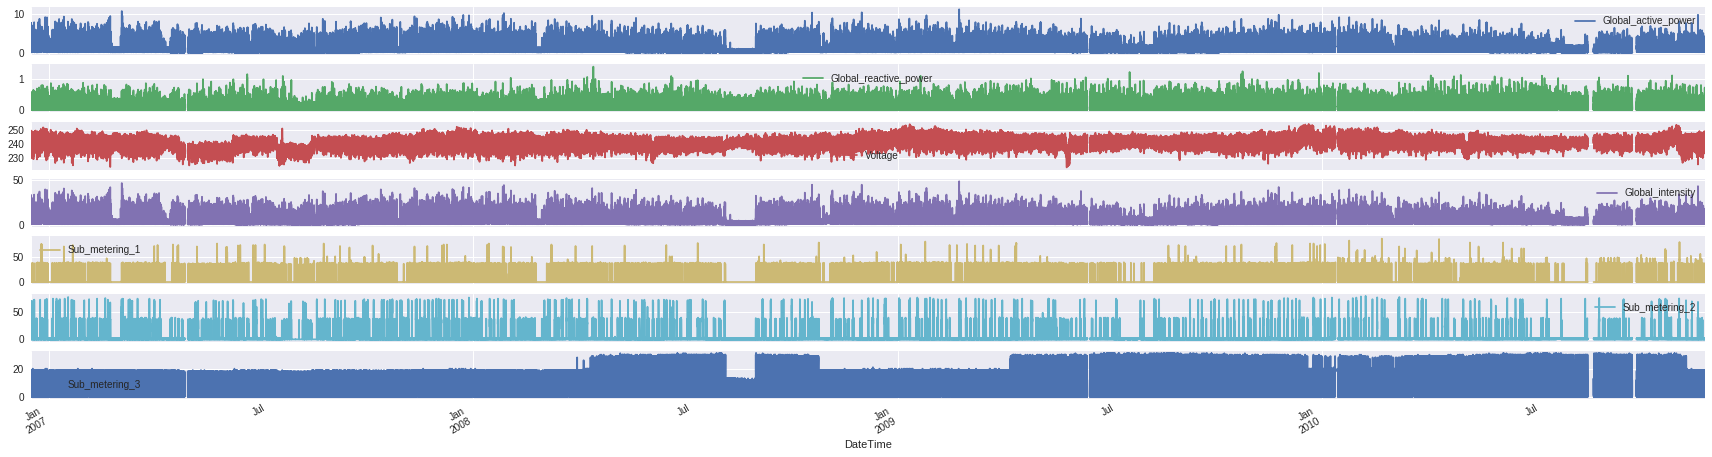

In [7]:
# Visualization data before imputation
energy_data.plot(subplots=True, figsize=(30,8))
plt.show()

Analysis :
- It can be observed that there are missing timestamps in the dataset.

> __Global Active Power__ : <br>
> > - It is observed that there is an yearly seasonal pattern in this feature with some spikes.

> __Global Reactive Power__ : <br>
> > - It is observed that there is a yearly seasonal pattern in this feature (with some spikes) but showing less variation as compared global_active_power.

> __Voltage__ : <br>
> > - It is observed that there is a strong repeating seasonal pattern in this feature across every year.
> > - At the beginning of every year it fluctuates a lot between 250 and 260 volts, but in between (near July) in every year it kinds of reduces and then spikes again as the year ends.

> __Global Intensity__ : <br>
> > - It is observed that the values do spike towards the beginning of each year but then go somewhat constant and then increase again during the end of each year.

> __Sub_metering_1__ : <br>
> > - This feature represents the kitchen area of the house. It is observed that values for this feature are strongly constant throughout every year with some spikes representing heavy usage of the kitchen during those time stamps.

> __Sub_metering_2__ : <br>
> > - This feature represents the laundry area of the house. It is observed that values for this feature are in periodic intervals throughout every year with some spikes representing heavy usage of laundry area during those time stamps.

> __Sub_metering_3__ : <br>
> > - This feature represents the electric water heater and the air conditioner in the house. 
> > > - For the year 2007: It is observed that the values almost remain constant throughout the year. electric water heater and air conditioner are equivalently used in their respective seasons.
> > > - For the year 2008: It is observed that the temperature increased as compared to previous. Hence, both devices were used extensively in their respective seasons.
> > > - For the Year 2009 and 2010: It is observed that from the month of May-2009 to November-2010 temperature became pretty ferocious (during both summer and winter) and both the appliances were used extensively.

## Year wise visualization 

In [8]:
def feature_visualize_yearly(data, feat_name):
    
    fig, axis = plt.subplots(4, 1, figsize=(30,8))
    
    for i, d in enumerate(zip(axis, list(data[feat_name].groupby(data.index.year))[1:])):
        d[0].plot(pd.DataFrame(d[1][1]), label=d[1][0])
        d[0].legend(loc='upper right', fontsize='12', frameon=True).get_frame().set_edgecolor('blue') 
    
    fig.text(0.40, 0.9, 'Year-Wise Analysis : %s ' %feat_name, va='center',  fontdict={'fontsize': 25})
    plt.show()    

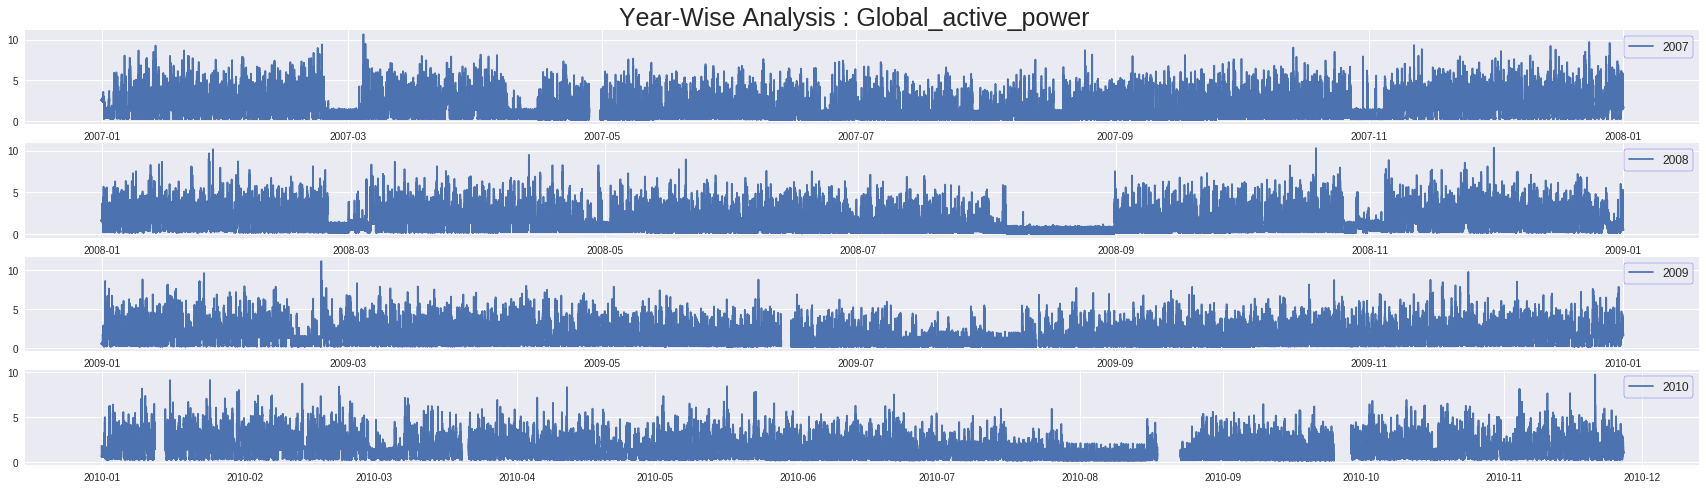

In [9]:
# Visualize Global_active_power
feature_visualize_yearly(data=energy_data, feat_name='Global_active_power')

Analysis:
- There are missing values in year 2007, 2009 and 2010.
- In every year, a decreasing trend can be observed from July to August and an increasing trend from September to the end of that year.

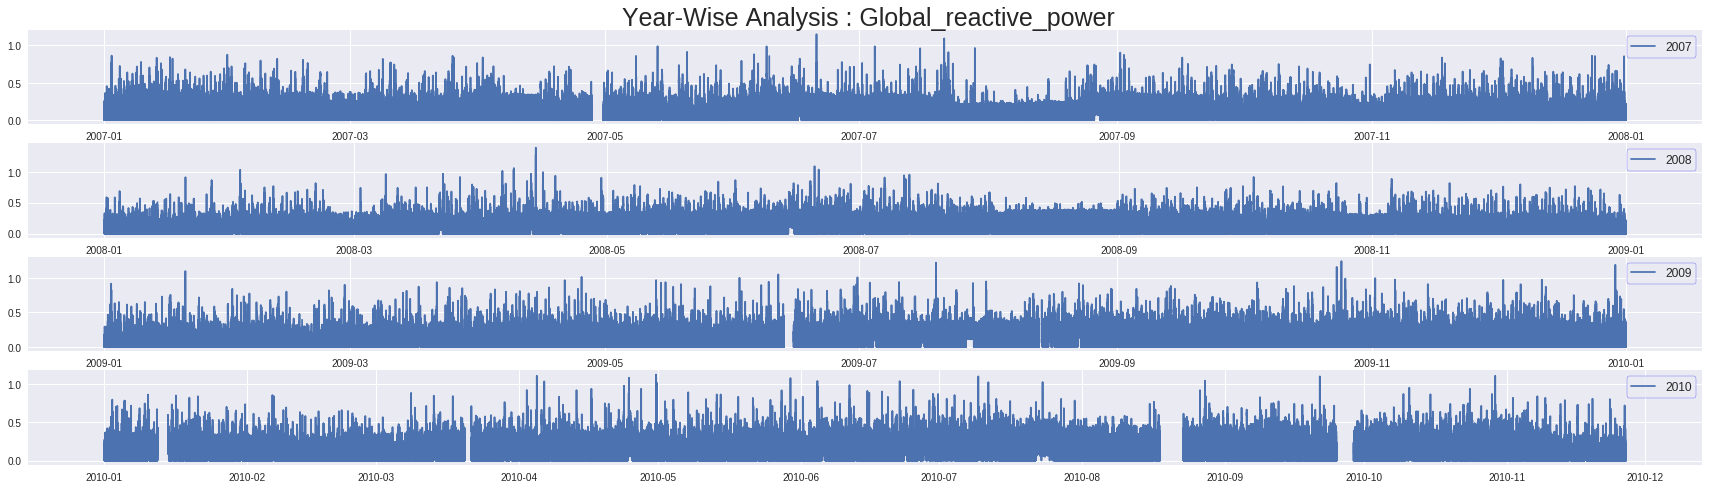

In [10]:
# Visualize Global_reactive_power
feature_visualize_yearly(data=energy_data, feat_name='Global_reactive_power')

Analysis:
- There are missing values in year 2007, 2009 and 2010.
- In every year, a constant trend  (not perfectly constant) can be observed with some spikes throughout the year.

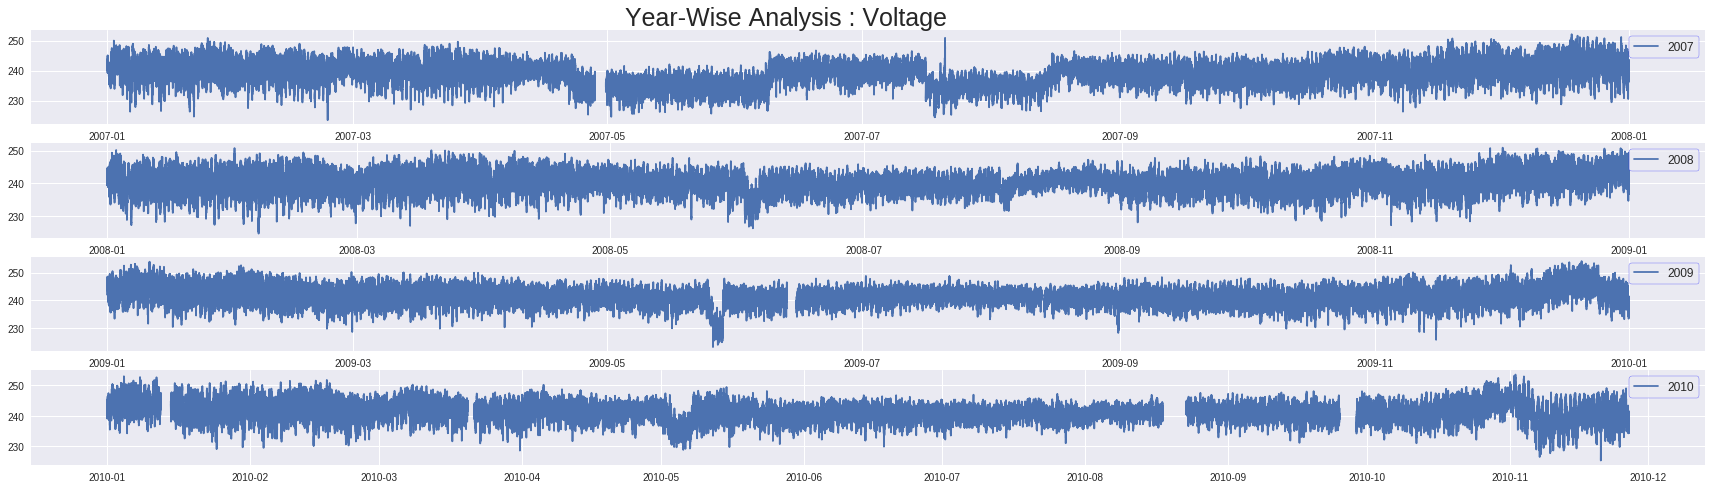

In [11]:
# Visualize Voltage
feature_visualize_yearly(data=energy_data, feat_name='Voltage')

Analysis:
- There are missing values in year 2007, 2009 and 2010.
- In every year, a seasonal repeating trend can be observed with some high values near the beginning and end of each year.

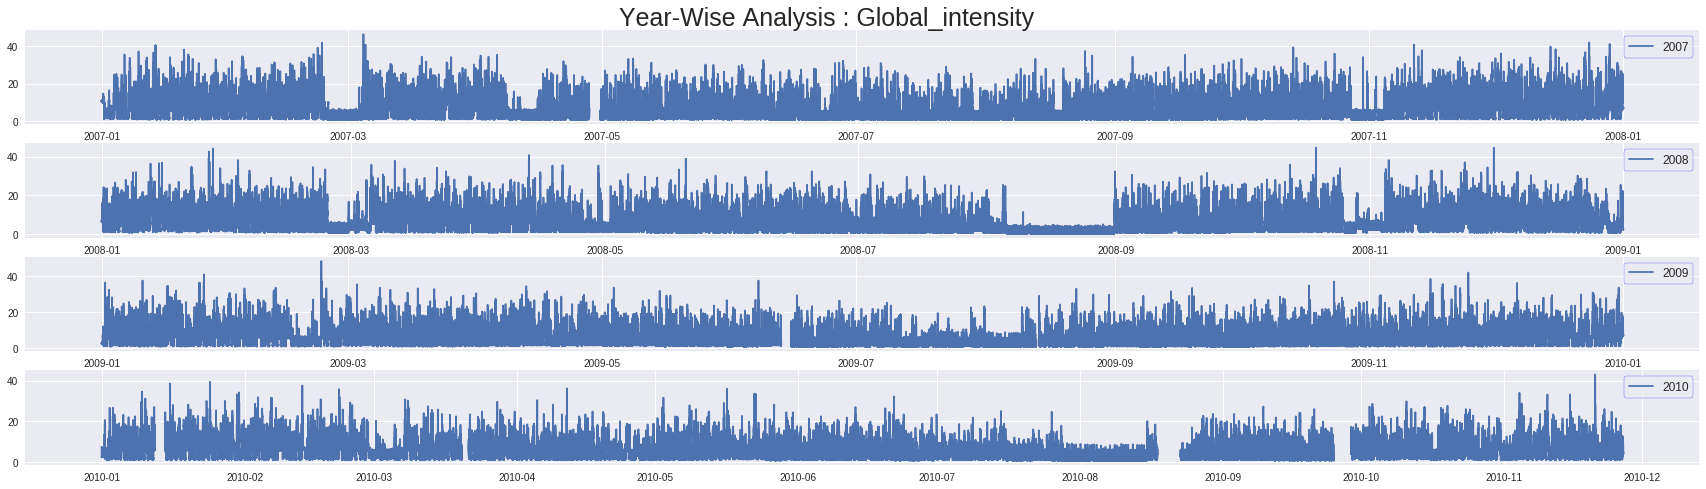

In [12]:
# Visualize Global_intensity
feature_visualize_yearly(data=energy_data, feat_name='Global_intensity')

Analysis:
- There are missing values in year 2007, 2009 and 2010.
- In every year, values of this feature lowers down during the month of August.

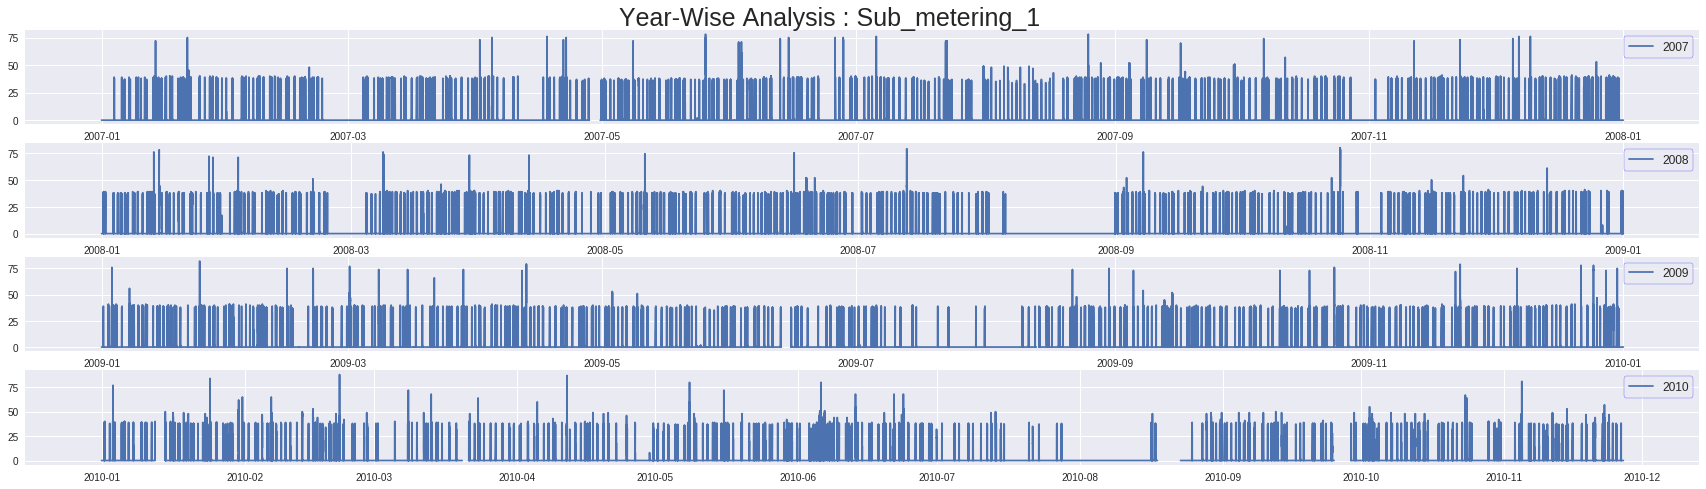

In [13]:
# Visualize Sub_metering_1
feature_visualize_yearly(data=energy_data, feat_name='Sub_metering_1')

Analysis:
- There are missing values in year 2007, 2009 and 2010.
- In every year, a not so periodic contant trend can be observed.

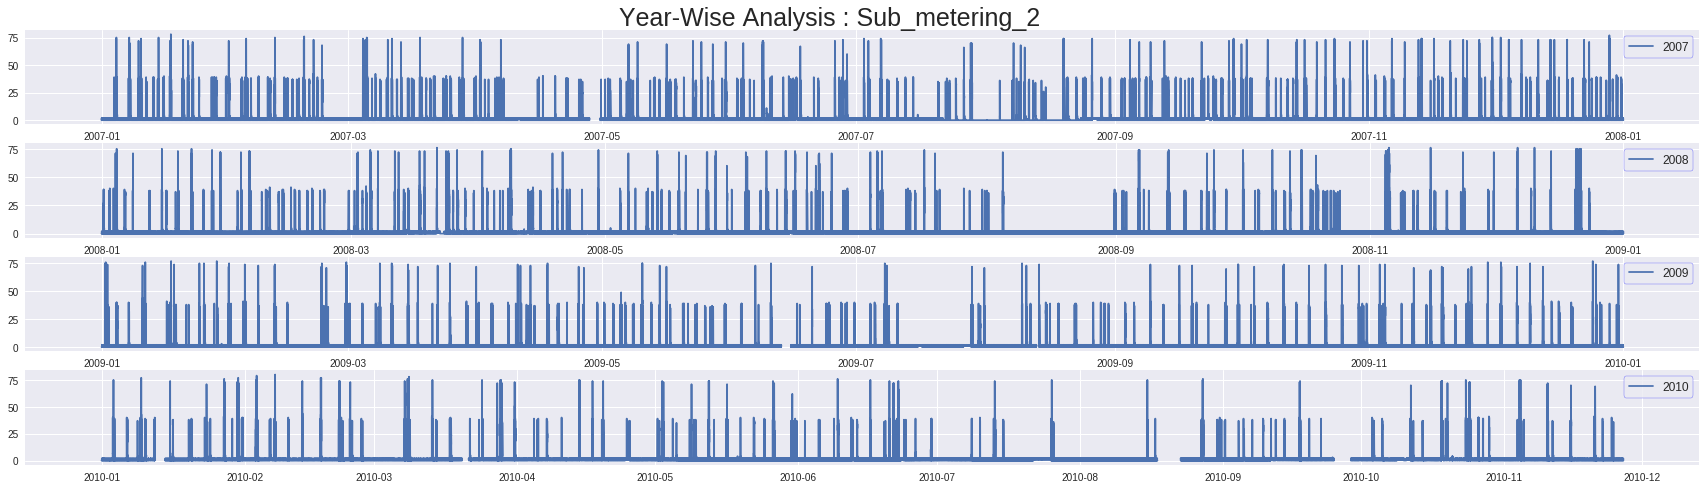

In [14]:
# Visualize Sub_metering_2
feature_visualize_yearly(data=energy_data, feat_name='Sub_metering_2')

Analysis:
- There are missing values in year 2007, 2009 and 2010.
- In every year, a not so periodic constant trend can be observed. But much less than sub_metering_1 because this feature represents laundry area and laundry room is not used that much often.

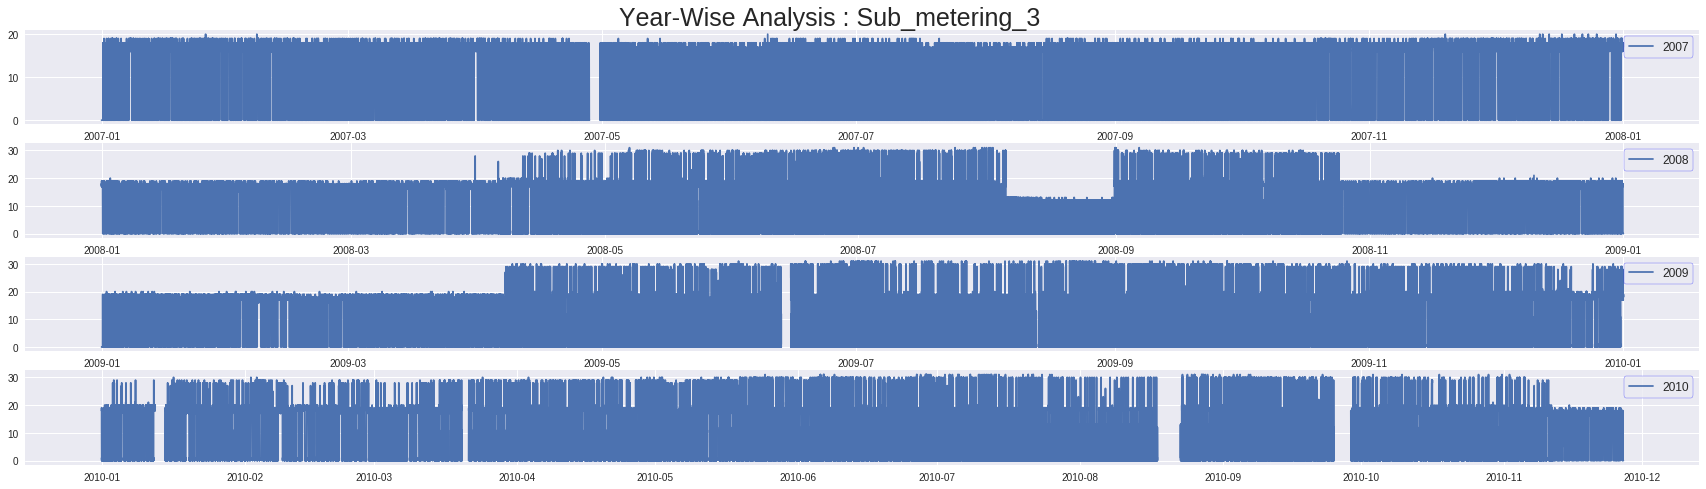

In [15]:
# Visualize Sub_metering_3
feature_visualize_yearly(data=energy_data, feat_name='Sub_metering_3')

Analysis:
- There are missing values in year 2007, 2009 and 2010.
- It can be observed that during the year 2010, the electric water heater and air conditioner were used extensively as compared to previous years.

## Impute Values

- After visualizing features on yearly granularity and observing the seasonal patterns, missing values in a particular feature can be replaced with the mean of that specific feature computed to its respective year.

In [16]:
def impute_nan_values(df):
    
    """
    Function to impute values
    
    Input : Dataframe with missing values
    Output : Dataframe with imputed values
    """
    
    data = []
    for d in list(energy_data.groupby(energy_data.index.year)):
        
        data.append(d[1].fillna(d[1].mean()))
        
    return pd.DataFrame(np.vstack(data), index=df.index, columns=df.columns)

In [17]:
# Impute NaN values
energy_data = impute_nan_values(energy_data)

In [18]:
# Check missing values after imputation
energy_data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

##  Data Visualization (After Imputation)

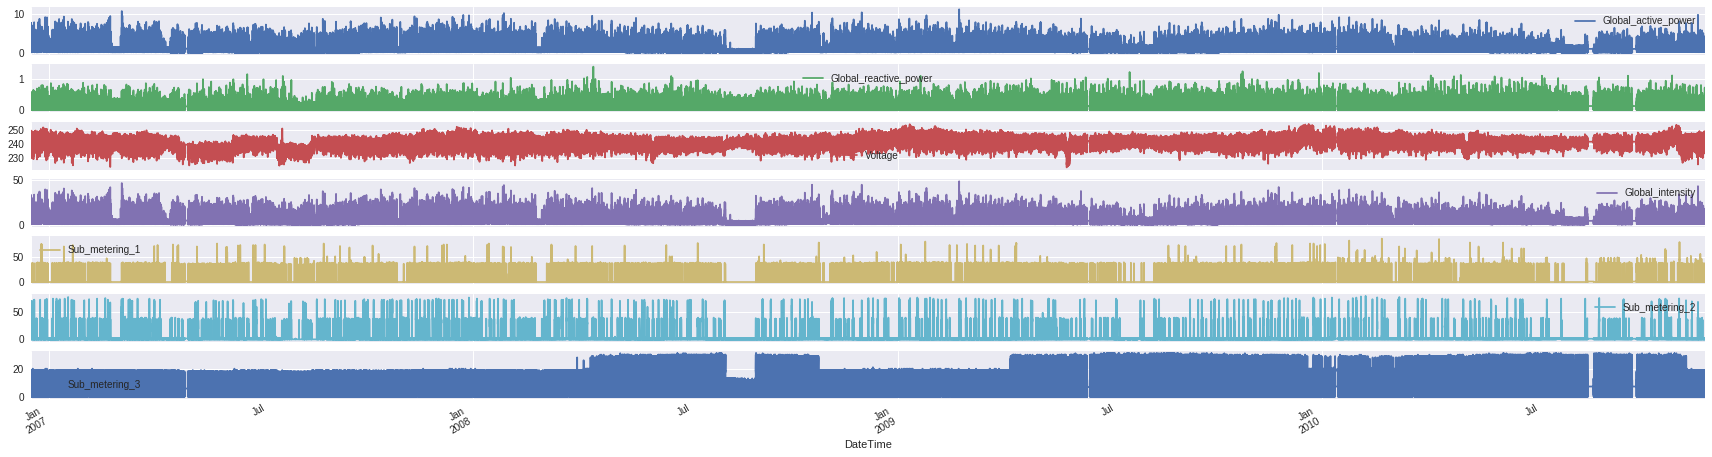

In [19]:
# Visualization energy data after imputation :
energy_data.plot(subplots=True, figsize=(30,8))
plt.show()

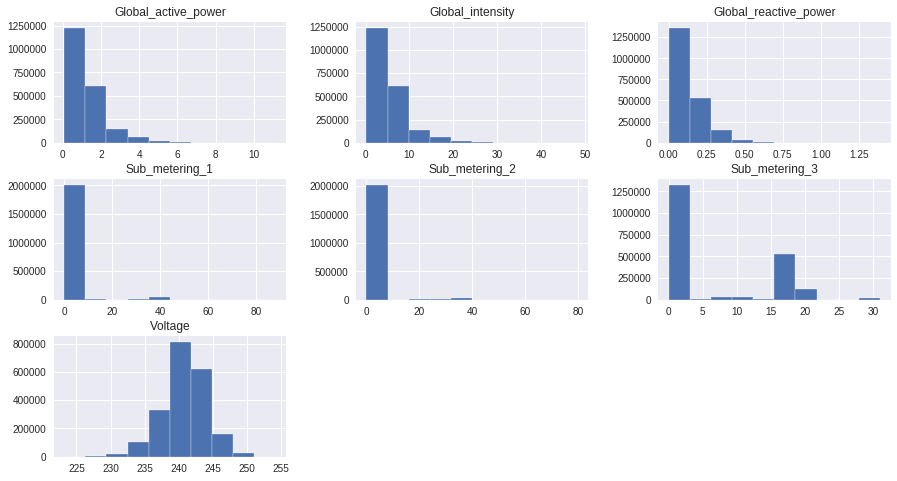

In [20]:
# Plot distribution of data after imputation
energy_data.hist(figsize=(15, 8))
plt.show()

Analysis :
- Voltage has close to normal distribution.
- Global_active_power, Global_intensity, Sub_metering_1, Sub_metering_2, Sub_metering_4 and Global_reactive_power have skewed distribution towards low values.

## Data resampling visualization
- The dataset is given on a minute level. 
- We will formulate the data on a different granularity level (downsample), which can be on hourly, daily or monthly basis etc.
- Visualizing resampled data will give on insights related to resampling level.

__Note__ : Three conditions are taken into consideration for selecting the granularity level.
> 1- Seasonal periodicity <br>
> 2- Distribution <br>
> 3- Correlation <br>

In [21]:
def resample_visualize(df, resample_level, title):
    
    """
    Function to plot the visualization, distribution and correlation of the resampled data.
    """
    
    
    # Resample data
    resampled_df = df.resample(resample_level).mean()
    
    print('Shape after %s resampling : %s ' %(title, resampled_df.shape))
    
    # Plot Resampled Data set
    resampled_df.plot(subplots=True, figsize=(30,8), title=title)
    plt.show()    
    
    # Plot distribution
    print(' \n\n------------------------------------------ %s resampled distribution Plot------------------------------------------' %title)
    resampled_df.hist(figsize=(15, 8))
    plt.show()
    
    # Plot correlation plot
    print(' \n\n------------------------------------------ %s resampled correlation Plot------------------------------------------' %title)
    plt.figure(figsize=(10,10))
    sns.heatmap(resampled_df.corr(), annot=True, fmt=".2f")
    plt.show()

Shape after Hourly resampling : (34589, 7) 


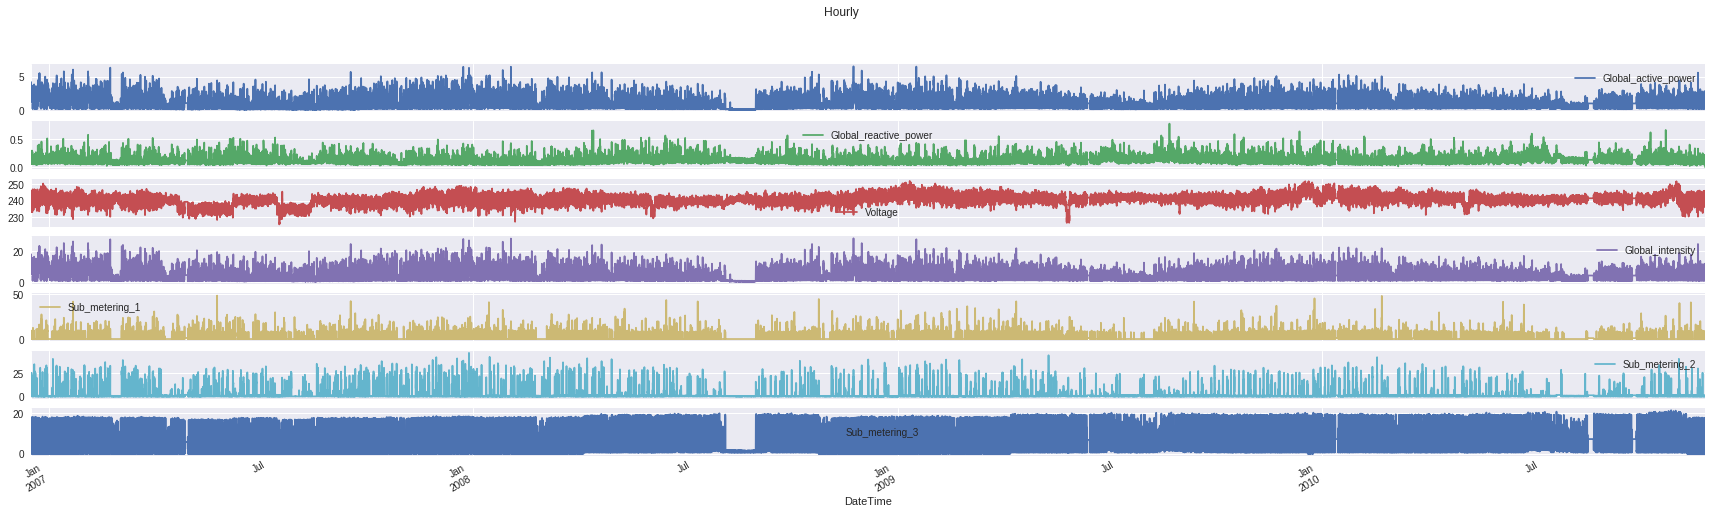

 

------------------------------------------ Hourly resampled distribution Plot------------------------------------------


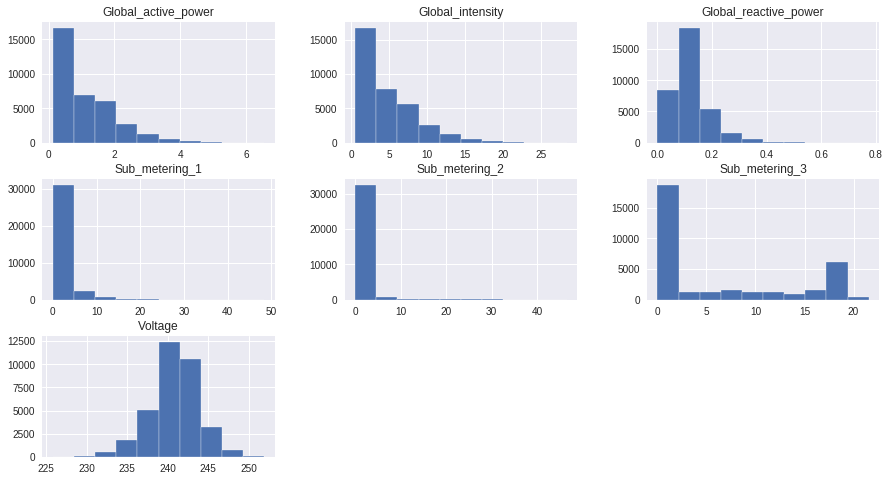

 

------------------------------------------ Hourly resampled correlation Plot------------------------------------------


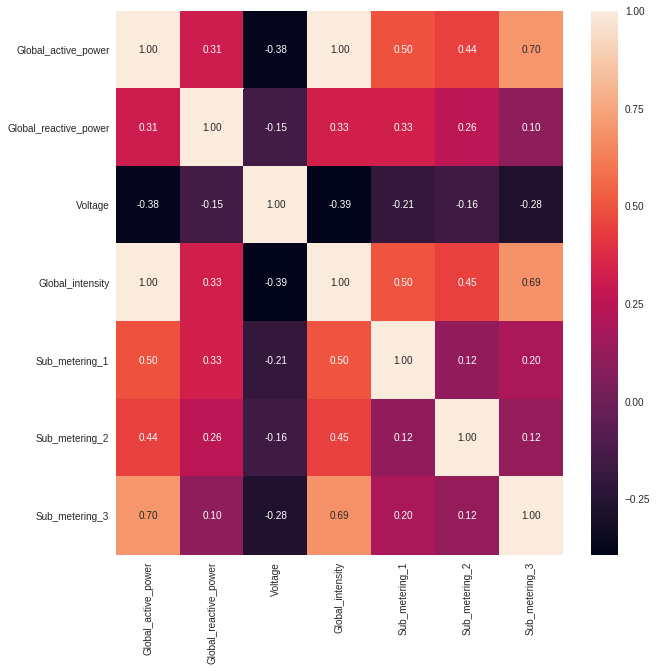

In [22]:
# visualize data on hourly basis
resample_visualize(energy_data, 'H', 'Hourly')

Shape after Daily resampling : (1442, 7) 


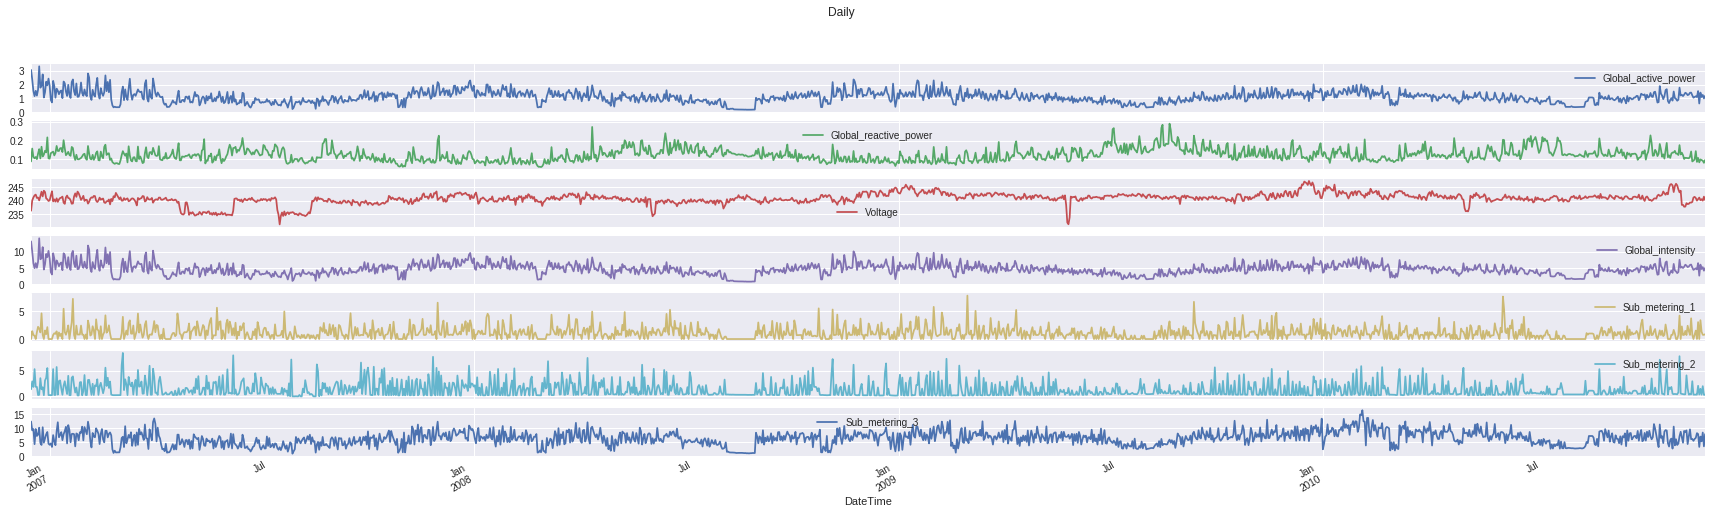

 

------------------------------------------ Daily resampled distribution Plot------------------------------------------


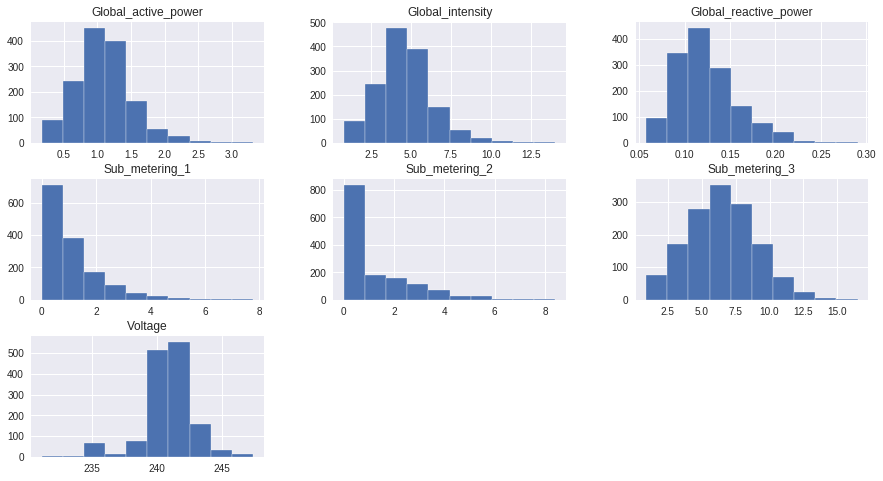

 

------------------------------------------ Daily resampled correlation Plot------------------------------------------


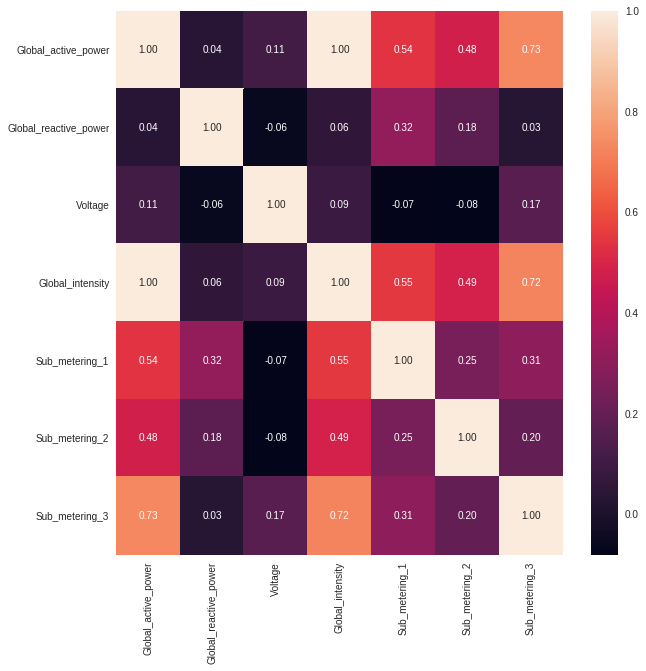

In [23]:
# visualize data on Daily basis
resample_visualize(energy_data, 'D', 'Daily')

Shape after Week resampling : (207, 7) 


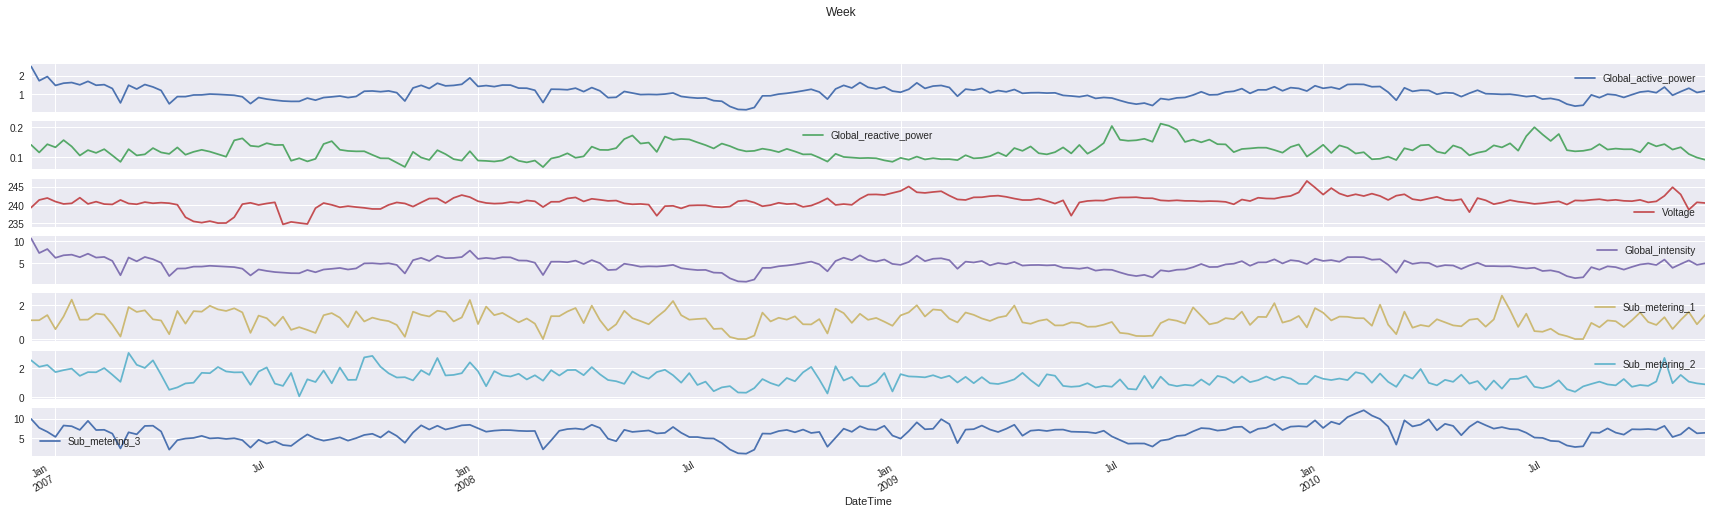

 

------------------------------------------ Week resampled distribution Plot------------------------------------------


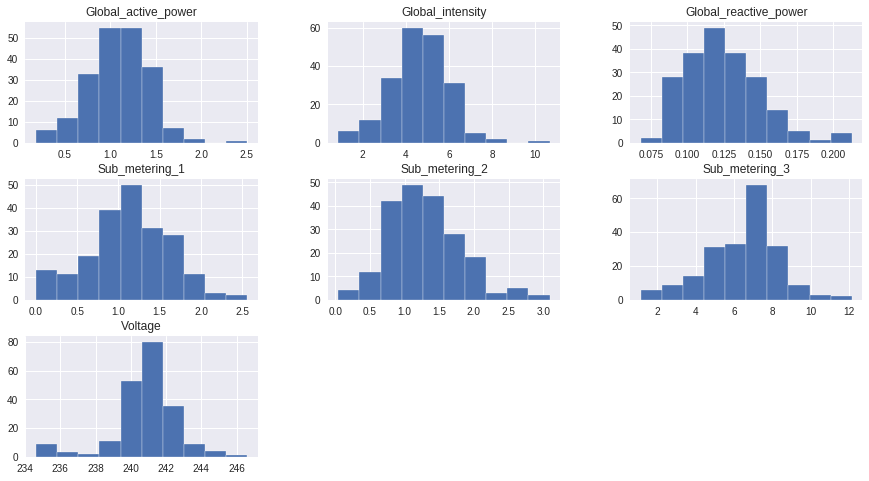

 

------------------------------------------ Week resampled correlation Plot------------------------------------------


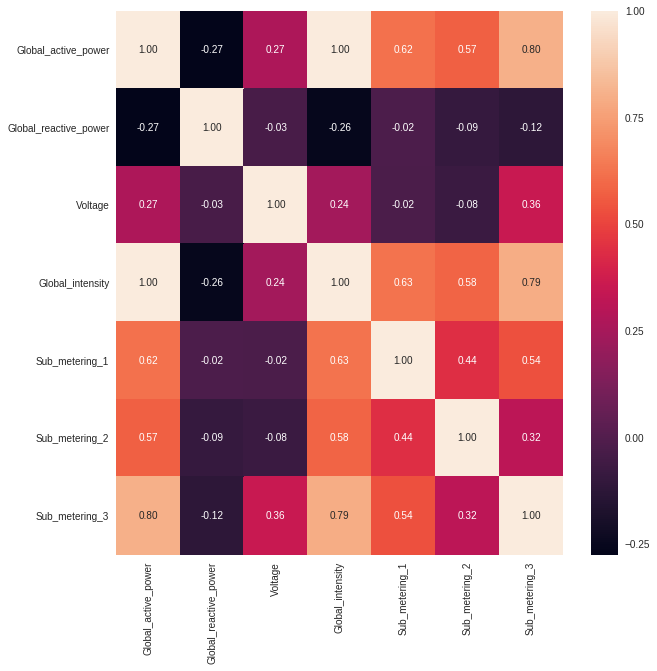

In [24]:
# visualize data on Weekly basis
resample_visualize(energy_data, 'W', 'Week')

Shape after Month resampling : (48, 7) 


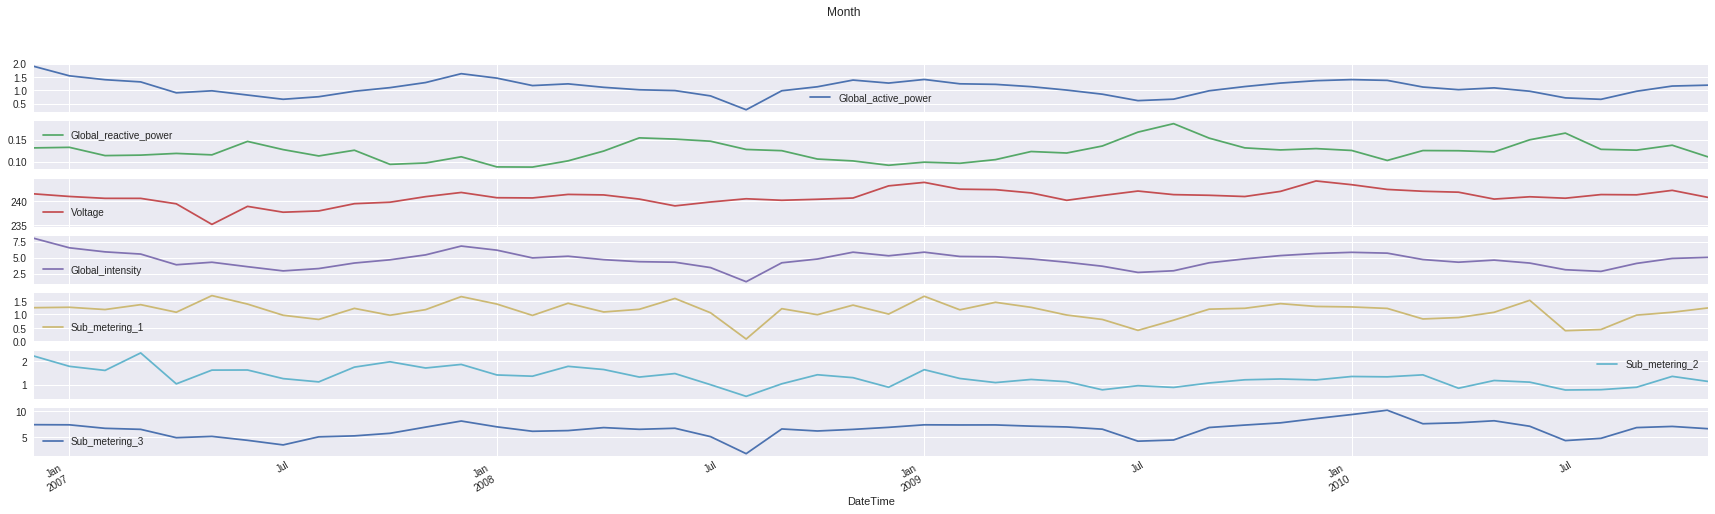

 

------------------------------------------ Month resampled distribution Plot------------------------------------------


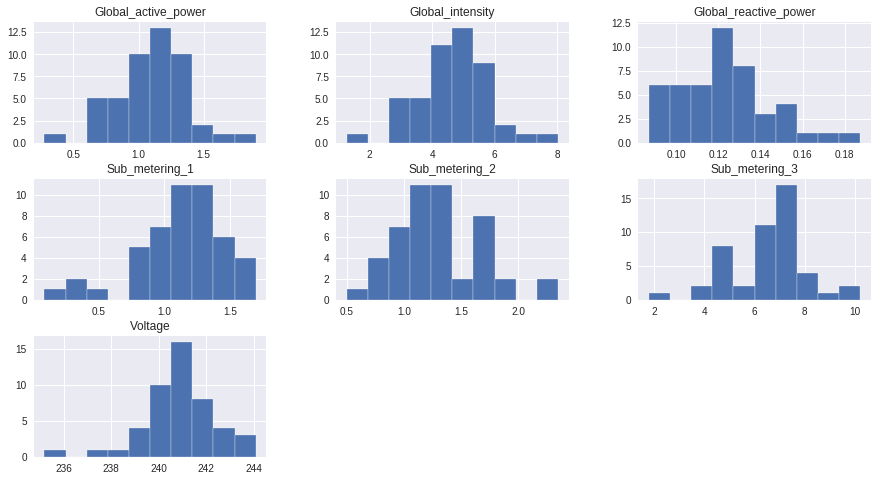

 

------------------------------------------ Month resampled correlation Plot------------------------------------------


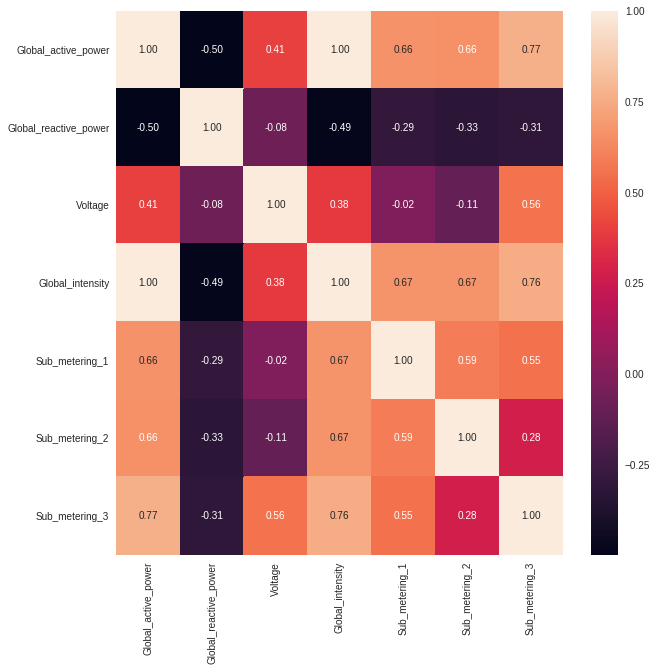

In [25]:
# visualize data on Monthly basis
resample_visualize(energy_data, 'M', 'Month')

Analysis :
- It is observed that as we increase the resampling criteria from hour to month :
> 1 - There is a drop in seasonal periodicity. <br>
> 2 - The distribution is becoming close to normal (not exactly normal) for some features. <br>
> 3 - An increase in correlation is observed between features.

- After observing, will resample the dataset on daily level.

## Resample data on daily level

In [26]:
# shape before resampling
print('Shape before resampling (minute) : ',energy_data.shape)

Shape before resampling (minute) :  (2075259, 7)


In [27]:
# resample the data on daily basis
energy_data = energy_data.resample('D').mean()

In [28]:
# Shape after resampling
print('Shape after resampling (daily) : ',energy_data.shape)

Shape after resampling (daily) :  (1442, 7)


# __Data Preprocessing__ 

###  Feature engineering

Active and reactive energy refer to the technical details of alternative current. In general terms, the active energy is the real power consumed by the household, whereas the reactive energy is the unused power in the lines. We can see that the dataset provides the active power as well as some division of the active power by main circuit in the house, specifically the kitchen, laundry, and climate control. These are not all the circuits in the household. The remaining watt-hours can be calculated from the active energy by first converting the active energy to watt-hours then subtracting the other sub-metered active energy in watt-hours, as follows:


\begin{equation}
Remaining\_active\_power = 
\frac{global\_active\_power * 1000}{60} - (sub\_metering\_1 + sub\_metering\_2 +sub\_metering\_3  )
\end{equation}

In [29]:
# Compute remaining active power
energy_data['sub_metering_remaining'] = (energy_data.Global_active_power * 1000  / 60 ) - (energy_data.Sub_metering_1 + energy_data.Sub_metering_2 + energy_data.Sub_metering_3)

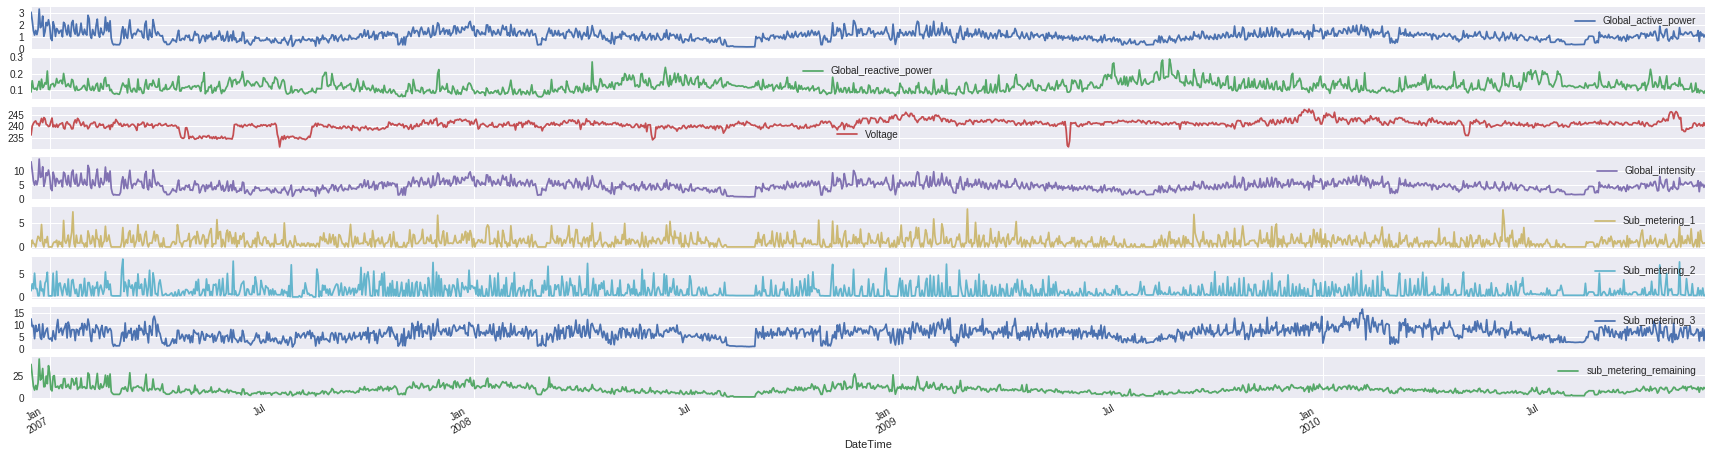

In [30]:
# visualize daily resampled dataframe
energy_data.plot(subplots=True, figsize=(30,8))
plt.show()

In [31]:
# descriptive statistics
energy_data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_remaining
count,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000
mean,1.092370,0.123746,240.842641,4.630881,1.120433,1.297111,6.467716,9.320915
std,0.416642,0.033797,2.023698,1.725752,1.097470,1.445627,2.542845,4.274769
min,0.173818,0.057811,231.088229,0.808333,0.000000,0.000000,0.894444,1.606690
25%,0.827201,0.099349,240.095785,3.519167,0.489757,0.301562,4.689236,6.544566
50%,1.078748,0.119140,240.983760,4.549375,0.779861,0.500347,6.504107,8.776134
75%,1.314143,0.140842,241.864816,5.524132,1.533160,1.884815,8.135764,11.457101
max,3.314851,0.290162,247.435007,14.028056,7.763289,8.409028,16.488194,42.872523


In [32]:
# Info of data
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Freq: D
Data columns (total 8 columns):
Global_active_power       1442 non-null float64
Global_reactive_power     1442 non-null float64
Voltage                   1442 non-null float64
Global_intensity          1442 non-null float64
Sub_metering_1            1442 non-null float64
Sub_metering_2            1442 non-null float64
Sub_metering_3            1442 non-null float64
sub_metering_remaining    1442 non-null float64
dtypes: float64(8)
memory usage: 101.4 KB


In [33]:
### The code below aims to balance out the week time perios in the dataset (Monday to Sunday), So dropped two rows from head and 5 rows from tail

# Get a feature for weekday name
energy_data['Day'] = energy_data.index.weekday_name

# Drop 2 rows from head to balance out weekely problem formulation
energy_data = energy_data.iloc[2:,:]

# Drop 5 row from tail to balance out weekely problem formulation
energy_data = energy_data.iloc[:-5,:]

In [34]:
# print
energy_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_remaining,Day
DateTime,,,,,,,,,
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722,13.214190,Monday
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472,9.119375,Tuesday
2006-12-20,1.545658,0.111804,242.308063,6.467361,0.000000,1.838889,9.765972,14.156111,Wednesday
2006-12-21,1.194741,0.100298,241.041106,5.037958,1.227429,1.824604,7.247097,9.613215,Thursday
2006-12-22,1.625929,0.129796,241.184549,6.872917,2.188194,0.243056,7.729861,16.937708,Friday


In [35]:
energy_data.tail()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_remaining,Day
DateTime,,,,,,,,,
2010-11-17,1.098633,0.098553,241.452243,4.631250,0.800694,0.340972,6.190972,10.977917,Wednesday
2010-11-18,1.147328,0.143192,241.016750,4.876944,1.510417,0.339583,6.561806,10.710324,Thursday
2010-11-19,1.090556,0.085367,240.046757,4.578472,0.000000,0.335417,8.273611,9.566898,Friday
2010-11-20,1.525699,0.106783,240.608333,6.472361,3.032639,2.046528,7.939583,12.409560,Saturday
2010-11-21,0.625632,0.083072,241.180194,2.637917,0.000000,0.351389,3.318056,6.757755,Sunday


In [36]:
# Drop Day feature
energy_data.drop(labels='Day', axis=1, inplace=True)

### Prediction Problem Formulation 
Problem : Given input data for a week (7 Days ~ & timesteps), predict the mean global_active_power for next week. <br>
Note: __We have just 1443 observations and  9 features__, the data is very less for deep learning models.


Input Features :
> Data from previous week (Monday to Sunday)
> > global_active_power <br>
> > global_reactive_power <br>
> > voltage <br>
> > global_intensity <br>
> > sub_metering_1 <br>
> > sub_metering_2 <br>
> > sub_metering_3 <br>
> > sub_metering_remaining

Output Feature :
>  For next week
> > Mean_global_active_power

### Data Preparation
> __Step 1-__ Split data into training and testing <br>
> __Step 2-__ Scale data <br>
> __Step 3-__ Convert the data to supervised learning problem <br>

In [37]:
def train_test_split(df):
    
    """
    Function to split the data
    
    Input : Dataframe
    Ouput : Training and testing dataframe 
    """ 
    
    # compute splot point
    end_idx = df.shape[0]* 70 // 100
    
    train_data = df.iloc[:end_idx, : ]
    test_data = df.iloc[end_idx:, :]
    
    return train_data, test_data

In [38]:
# Split the data into train and test
X_train, X_test = train_test_split(energy_data)

In [39]:
def scale_data(train, test):
    
    """
    Function to scale the data
    
    Input : Unscaled training and testing data
    Output : Scaled training and testing data
    """
    
    scaler = MinMaxScaler().fit(train)
    
    return scaler.transform(train), scaler.transform(test), scaler

In [40]:
# Scale the data
X_train, X_test, scaler = scale_data(X_train, X_test)

In [41]:
def convert_to_supervised(df):
    
    """
    Function to convert the data into a supervised regression problem 
    Note : The aim of this project is to use the input features for every day from the last week and predict the mean of global active power for the next week.
    
    Input : Data (2-Dimensional)
    
    Output : Input features (3-Dimensional) , Output feature (2-Dimensional)
    """
    
    input_features = []
    ouput_feature = []
    
    len_df = df.shape[0]
    
    for i in range(len_df):
        
        end_idx = i + 7 
        
        if end_idx > len_df-7:
            break
            
        input_x , output_y = df[i:end_idx, 1:], df[end_idx: end_idx+7, 0]
        
        input_features.append(input_x)
        ouput_feature.append(output_y)
    
    return np.array(input_features), np.mean(np.array(ouput_feature), axis=1)

In [42]:
# Split the training data into input features and out feature
X_train, Y_train = convert_to_supervised(X_train)
print('Shape of (training data) input features : %s and ouput feature %s' % (X_train.shape, Y_train.shape))

Shape of (training data) input features : (991, 7, 7) and ouput feature (991,)


In [43]:
# Split the testing data into input features and out feature
X_test, Y_test = convert_to_supervised(X_test)
print('Shape of (testing data) input features : %s and ouput feature %s' % (X_test.shape, Y_test.shape))

Shape of (testing data) input features : (418, 7, 7) and ouput feature (418,)


# __Model Prediciton__

In [44]:
def model_rmse(y_true, y_pred):
    
    """
    Function to integrate rmse metric into Model to monitor the model performance
    
    Input : y_true, y_pred
    Output : RMSE value computed between y_true and y_pred
    """
    
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [45]:
def compute_rmse(y_pred, y_true):
    
    """
    Function to compute RMSE between predicted and true values
    
    Input : y_true, y_pred
    
    Output : RMSE
    """
    
    return np.sqrt(mean_squared_error(y_pred, y_true))

In [46]:
def plot_model_performance(h, image_name):
    
    """
    Function to plot the model history, which includes model loss 'MSE' and model metric 'RMSE'
    
    Input : Model history
    """
    
    fig, ax = plt.subplots(1, 2, figsize=(20,5))
    
    # Plot model loss (MSE)
    ax[0].plot(h.history['val_loss'], label = 'Test')
    ax[0].plot(h.history['loss'], label = 'Train')
    ax[0].set_title('Plot Model Loss (MSE)')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Mean Squared Error')
    ax[0].legend(loc='upper right')
    
    
    # Plot model evaluation metric (RMSE)
    ax[1].plot(h.history['val_model_rmse'], label='Test')
    ax[1].plot(h.history['model_rmse'], label='Train')
    ax[1].set_title('Plot Model Metric (RMSE)')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Root Mean Squared Error')
    ax[1].legend(loc='upper right')
    
    fig.suptitle('Model Performance Evaluation Plots')
    plt.savefig('Images/'+image_name+'loss_and_metric.png', dpi=300)
    plt.show()

In [47]:
def plot_pred_vs_true(y_pred, y_true, image_name):
    
    """
    Function to plot predictions vs true values.
    
    Input : y_pred, y_true
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(20,5))
    
    ax.plot(y_pred, label='Predictions')
    ax.plot(y_true, label='True')
    ax.set_ylabel('Global Active Power')
    ax.set_xlabel('Data point Index (Week)')
    ax.legend(loc='upper right')
    
    plt.title('True Values VS Predicted Values')
    plt.savefig('Images/'+image_name+'pred_vs_true.png', dpi=300)
    plt.show()

### CNN Model

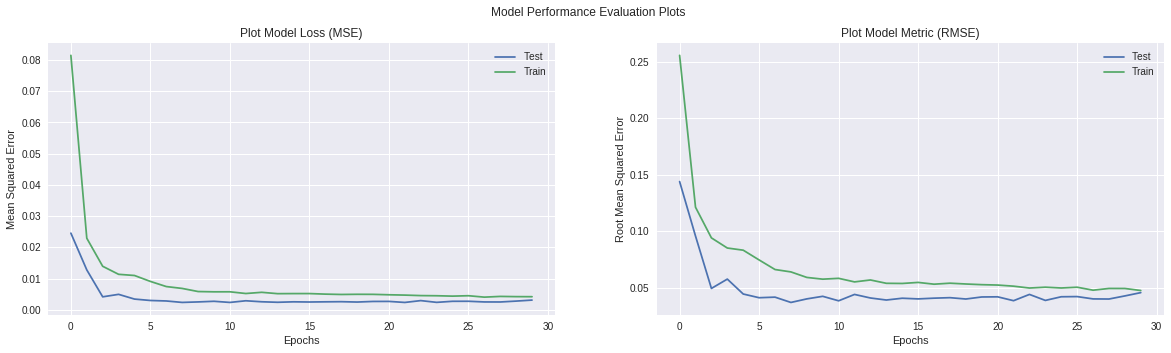

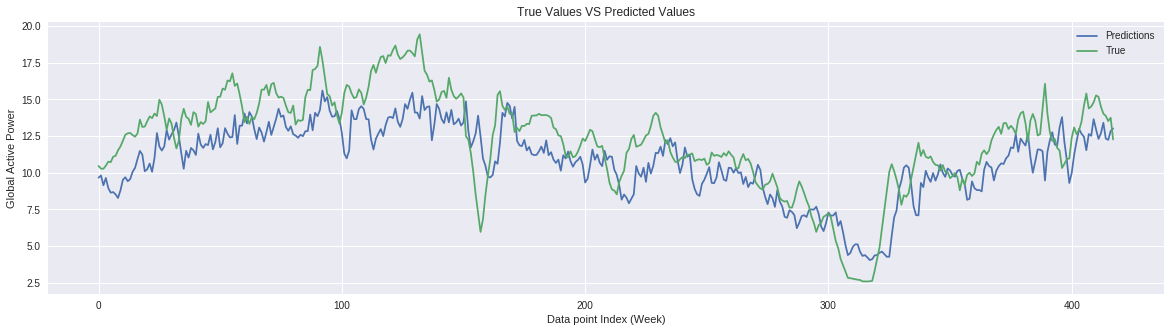

RMSE value for CNN Model  : 0.05554 


In [48]:
# Define CNN model
CNN_Model = Sequential()
CNN_Model.add(Conv1D(filters=64, kernel_size=4, activation='relu',input_shape=(X_train.shape[1], X_train.shape[2])))
CNN_Model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
CNN_Model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))           
CNN_Model.add(MaxPooling1D(pool_size=1))
CNN_Model.add(Flatten())
CNN_Model.add(Dense(100, activation='relu'))
CNN_Model.add(Dropout(0.3))
CNN_Model.add(Dense(20, activation='relu'))
CNN_Model.add(Dense(1))
    
# Compile CNN Model
CNN_Model.compile(optimizer='adam', loss ='mean_squared_error', metrics=[model_rmse])

# Fit the CNN model
history = CNN_Model.fit(X_train, Y_train, batch_size=128, validation_data=(X_test, Y_test), epochs=30, verbose=0, shuffle=False)

# Plot CNN model history
plot_model_performance(history, 'CNN-Model')

# Plot CNN model predictions vs True values
plot_pred_vs_true(CNN_Model.predict(X_test) / scaler.scale_[-1], Y_test / scaler.scale_[-1], 'CNN-Model')

# Evaluate rmse for CNN Model
print('RMSE value for CNN Model  : %.5f ' % compute_rmse(CNN_Model.predict(X_test), Y_test))

Analysis :

> Model Performance Evaluation Plots :
> > 1 - Plotting the model loss (MSE)  an model metric (RMSE) indicates a good fit rather than over-fit or an undner-fit. <br>
> > 2 - It is interesting to observe that the training loss (MSE) and metric (RMSE) is more than testing. It can be stated that training data consists of data with more complex underlying latent structure as compared to testing data.

> True Values Vs Predicted Values :
> > It can be observed that CNN learns the spatial seasonal periodic structure but fails to prefectly capture the underlying sequential nature of the data. Next model will test on this data would be an LSTM.

### LSTM Model

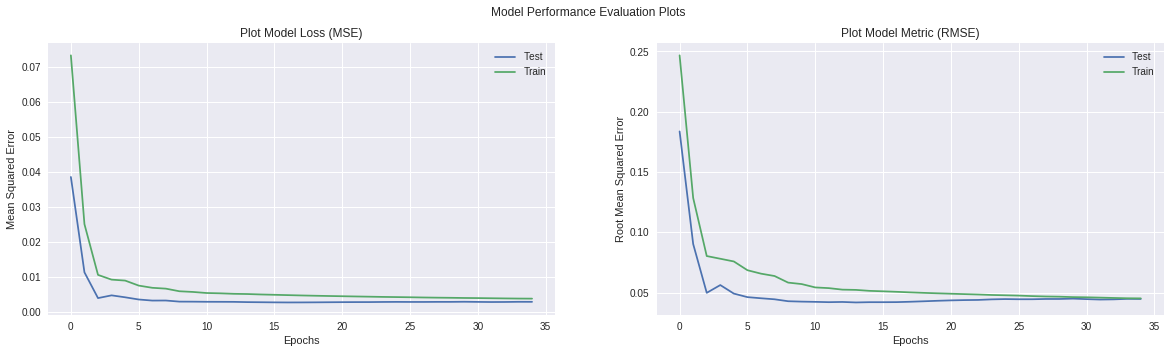

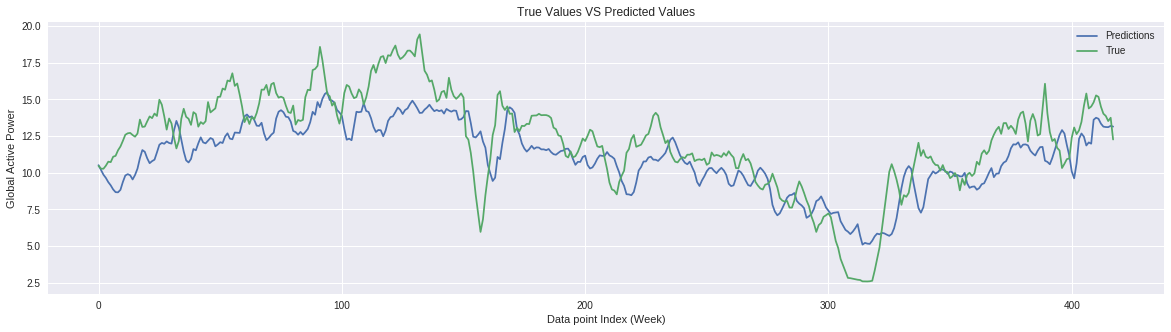

RMSE value for Stacked LSTM Model  :  0.05389 


In [49]:
# Define model
lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
lstm_model.add(LSTM(80, activation='relu',  return_sequences=True))
lstm_model.add(LSTM(50, activation='relu'))
lstm_model.add(Dense(20, activation='relu'))
lstm_model.add(Dense(1))

# Compile Model
lstm_model.compile(optimizer='adam', loss ='mean_squared_error', metrics=[model_rmse])

# Fit the model
history = lstm_model.fit(X_train, Y_train, batch_size=128, validation_data=(X_test, Y_test), epochs=35, verbose=0, shuffle=False)

# Plot model history
plot_model_performance(history, 'LSTM-Model')

# Plot Model predictions vs True values
plot_pred_vs_true(lstm_model.predict(X_test) / scaler.scale_[-1], Y_test / scaler.scale_[-1], 'LSTM-Model')

# Evaluate rmse for LSTM
print('RMSE value for Stacked LSTM Model  :  %.5f '  % compute_rmse(lstm_model.predict(X_test), Y_test))

Analysis:
> Model Performance Evaluation Plots :
> > 1 - Plotting the model loss (MSE)  an model metric (RMSE) indicates a good fit rather than over-fit or an undner-fit. <br>
> > 2 - It is interesting to observe that the training loss (MSE) and metric (RMSE) is more than testing. It can be stated that training data consists of data with more complex underlying latent structure as compared to testing data.

> True values VS Preicted Values
> > It can be observed that there is a slight improvement as compared to CNN model as RMSE value computed for LSTM is slightly less that the RMSE vale computed using CNN model.
> > Next model CNN-LSTM hybrid model might give some improvement over LSTM and CNN model.

#### CNN-LSTM Model

In [50]:
def prep_data_cnn_lstm_model(df, rsh_params, mode):
    
    """
    Function to prepare the data for CNN-LSTM Model and ConvLSTM2D
    """
    
    # Split the data into train and test
    X_train, X_test = train_test_split(energy_data)
    
    # Sclae the data
    X_train, X_test, _ = scale_data(X_train, X_test) 
    
    # Split the training data into input features and out feature
    X_train, Y_train = convert_to_supervised(X_train)
    
    # Split the testing data into input features and out feature
    X_test, Y_test = convert_to_supervised(X_test)
    
    if mode == 'cnn-lstm':   
        
        # Convert training data to 4-dimensional
        X_train = X_train.reshape((-1, rsh_params['cnn-lstm']['sub_sequences'], rsh_params['cnn-lstm']['timesteps'], rsh_params['cnn-lstm']['features']))
        
    
        # Convert testing data to 4-dimensional
        X_test = X_test.reshape((-1, rsh_params['cnn-lstm']['sub_sequences'], rsh_params['cnn-lstm']['timesteps'], rsh_params['cnn-lstm']['features']))
    
    elif mode == 'convlstm2d':
        
        # Convert training data to 4-dimensional
        X_train = X_train.reshape((-1, rsh_params['convlstm2d']['sub_sequences'], rsh_params['convlstm2d']['rows'], rsh_params['convlstm2d']['cols'], rsh_params['convlstm2d']['features']))
        
    
        # Convert testing data to 4-dimensional
        X_test = X_test.reshape((-1, rsh_params['convlstm2d']['sub_sequences'], rsh_params['convlstm2d']['rows'], rsh_params['convlstm2d']['cols'], rsh_params['convlstm2d']['features']))
        
    
    print('Shape of X_train after reshaping : ',  X_train.shape)
    print('Shape of X_test after reshaping : ', X_test.shape)
    
    return X_train, Y_train, X_test, Y_test

In [51]:
# define reshaping parameters for CNN-LSTM Model
reshape_params = { 'cnn-lstm' : { 'sub_sequences' : 7, 'timesteps' : 1, 'features' : 7 },
                  'convlstm2d' : { 'sub_sequences' : 7, 'rows' :1,  'cols' : 1, 'features' : 7 }
                }

Shape of X_train after reshaping :  (991, 7, 1, 7)
Shape of X_test after reshaping :  (418, 7, 1, 7)


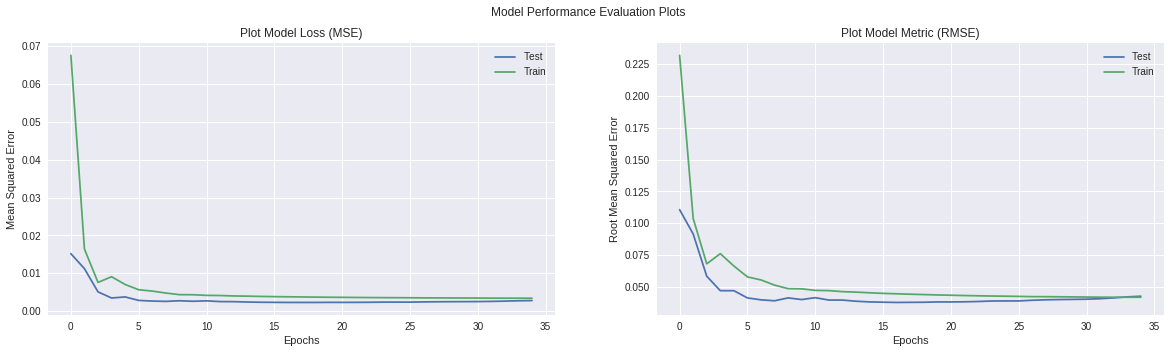

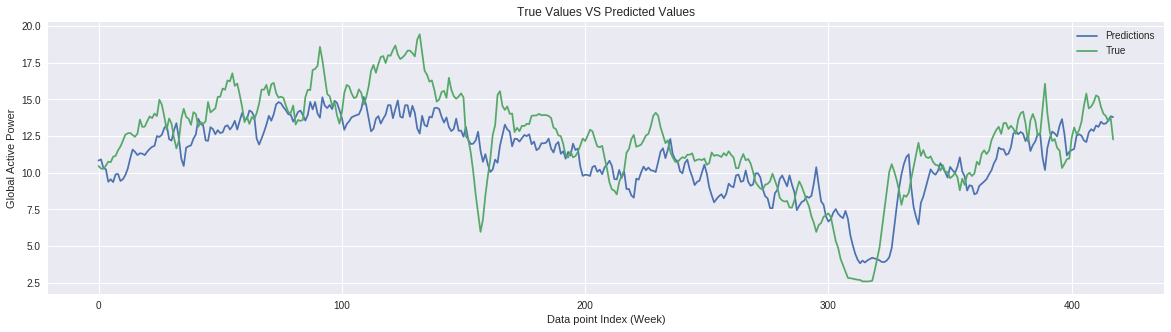

RMSE value for Stacked CNN-LSTM Model  :  0.05242 


In [52]:
# Prepare data for CNN-LSTM
X_train, Y_train, X_test, Y_test = prep_data_cnn_lstm_model(energy_data, reshape_params, 'cnn-lstm')

# Define CNN-LSTM Model
cnn_lstm = Sequential()
cnn_lstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=(7,1,7))))
cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=1)))
cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=1)))
cnn_lstm.add(TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu')))
cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=1)))
cnn_lstm.add(TimeDistributed(Conv1D(filters=16, kernel_size=1, activation='relu')))
cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=1)))

cnn_lstm.add(TimeDistributed(Flatten()))
cnn_lstm.add(LSTM(50, activation='relu'))
cnn_lstm.add(Dense(20))
cnn_lstm.add(Dense(1))

# Compile CNN-LSTM Model
cnn_lstm.compile(optimizer='adam',  loss ='mean_squared_error', metrics=[model_rmse])

# Fit the CNN-LSTM model
history = cnn_lstm.fit(X_train, Y_train, batch_size=128, validation_data=(X_test, Y_test), epochs=35, verbose=0, shuffle=False)

# Plot CNN-LSTM model history
plot_model_performance(history, 'CNN-LSTM Model')

# Plot CNN-LSTM Model predictions vs True values
plot_pred_vs_true(cnn_lstm.predict(X_test) / scaler.scale_[-1], Y_test / scaler.scale_[-1], 'CNN-LSTM Model')

# Evaluate rmse for CNN-LSTM
print('RMSE value for Stacked CNN-LSTM Model  :  %.5f '  % compute_rmse(cnn_lstm.predict(X_test), Y_test))

Analysis:
> Model Performance Evaluation Plots :
> > 1 - Plotting the model loss (MSE)  an model metric (RMSE) indicates a good fit rather than over-fit or an undner-fit. <br>
> > 2 - It is interesting to observe that the training loss (MSE) and metric (RMSE) is more than testing. It can be stated that training data consists of data with more complex underlying latent structure as compared to testing data.

> True values VS Preicted Values
> > It can be observed that there is a slight improvement as compared to CNN and LSTM model as RMSE value for the CNN-LSTM model is the lowest. <br>
> > Next ConvLSTM2D model can be used, it is expected that ConvLSTM2D shows a bit more improvement with less deep structure.

### ConvLstm2D

Shape of X_train after reshaping :  (991, 7, 1, 1, 7)
Shape of X_test after reshaping :  (418, 7, 1, 1, 7)


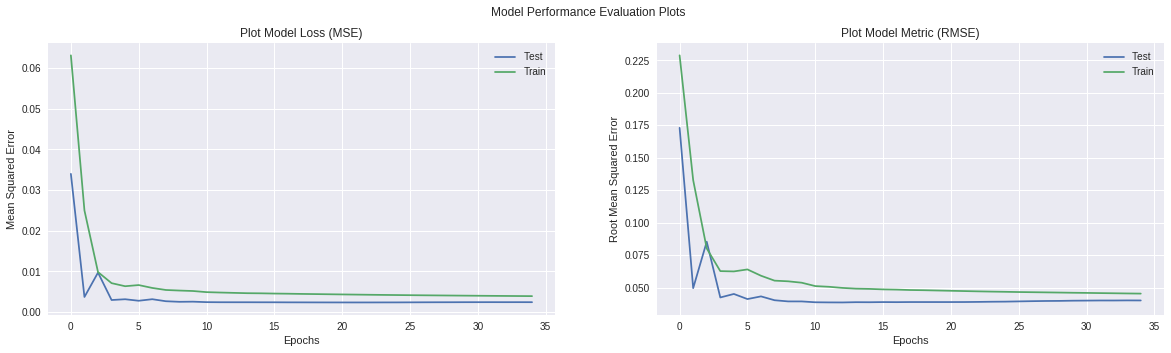

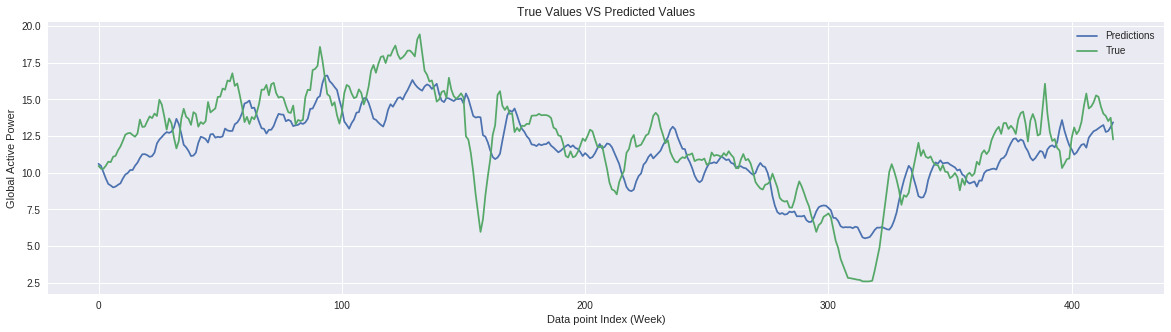

RMSE value for Stacked ConvLSTM Model  :  0.04904 


In [53]:
# Prepare data from ConvLSTM2D
X_train, Y_train, X_test, Y_test = prep_data_cnn_lstm_model(energy_data, reshape_params, 'convlstm2d')

# Create Convlstm2d Model
convlstm2d = Sequential()
convlstm2d.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(7, 1, 1,7), return_sequences=True))
convlstm2d.add(ConvLSTM2D(filters=32, kernel_size=(1,1), activation='relu'))
convlstm2d.add(Flatten())
# convlstm2d.add(Dense(20))
convlstm2d.add(Dense(1))

# Compile Convlstm2D model
convlstm2d.compile(optimizer='adam',  loss ='mean_squared_error', metrics=[model_rmse])

# Fit Convlstm2d model
history = convlstm2d.fit(X_train, Y_train, batch_size=128, validation_data=(X_test, Y_test), epochs=35, verbose=0, shuffle=False)

# Plot ConvLSTM2d model history
plot_model_performance(history, 'ConvLstm2D Model')

# Plot ConvLSTM2d Model predictions vs True values
plot_pred_vs_true(convlstm2d.predict(X_test) / scaler.scale_[-1], Y_test / scaler.scale_[-1], 'ConvLstm2D Model')

# Evaluate rmse for ConvLSTM2d
print('RMSE value for Stacked ConvLSTM Model  :  %.5f '  % compute_rmse(convlstm2d.predict(X_test), Y_test))

Analysis:
> Model Performance Evaluation Plots :
> > 1 - Plotting the model loss (MSE)  an model metric (RMSE) indicates a good fit rather than over-fit or an undner-fit. <br>
> > 2 - It is interesting to observe that the training loss (MSE) and metric (RMSE) is more than testing. It can be stated that training data consists of data with more complex underlying latent structure as compared to testing data.

> True values VS Preicted Values
> > It is observed that ConvLSTM2D model performs much better than other models (CNN, LSTM and CNN-LSTM), but the data available for training was very less considering deep learning models, hence given more data we can improve the model performance to make more accurate predictions.